# imports and functions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.losses import MAE

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score,  r2_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

import joblib

In [ ]:
#tokenization with our own solution (for research topic)

class SimpleTokenizer:
    def __init__(self, num_words=None):
        self.num_words = num_words
        self.word_index = {}
        self.index_word = {}

    def fit_on_texts(self, texts):
        word_counts = defaultdict(int)
        for text in texts:
            for word in text.split():
                word_counts[word] += 1

        sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        if self.num_words:
            sorted_words = sorted_words[:self.num_words - 1]

        self.word_index = {word: i + 1 for i, (word, _) in enumerate(sorted_words)}
        self.index_word = {i: word for word, i in self.word_index.items()}

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequences.append([self.word_index.get(word, 0) for word in text.split()])
        return sequences

    def pad_sequences(self, sequences, maxlen):
        padded_sequences = np.zeros((len(sequences), maxlen), dtype=int)
        for i, seq in enumerate(sequences):
            if len(seq) > maxlen:
                padded_sequences[i, :] = seq[:maxlen]
            else:
                padded_sequences[i, -len(seq):] = seq
        return padded_sequences

In [ ]:
def show(df):
  df['Rating'].plot(kind='hist', bins=20, title='Rating')
  plt.gca().spines[['top', 'right',]].set_visible(False)
  df.info()

In [ ]:
def custom_accuracy(y_true, y_pred):
    tolerance = 0.5
    return np.mean(np.abs(y_true - y_pred) <= tolerance)

In [ ]:
def predict_review_rating(review_text, tok_name, model_name):
    tokenizer = joblib.load(f'{tok_name}.pkl')
    model = load_model(f'{model_name}.h5', custom_objects={'mse': metrics.MeanSquaredError})

    review_sequence = tokenizer.texts_to_sequences([review_text])
    review_padded = pad_sequences(review_sequence, maxlen=500)

    predicted_rating = model.predict(review_padded)
    return round(predicted_rating[0][0], 2)

# Benchmark models

In [ ]:
def run(data, tok_name = 'tokenizer', model_name = 'model', save = False):
  simple_tokenizer = SimpleTokenizer(num_words=5000)
  simple_tokenizer.fit_on_texts(data['Review'])
  X = simple_tokenizer.texts_to_sequences(data['Review'])
  X = simple_tokenizer.pad_sequences(X, maxlen=500)
  y = data['Rating'].values

  # tokenizer = Tokenizer(num_words=5000)
  # tokenizer.fit_on_texts(data['Review'])
  # X = tokenizer.texts_to_sequences(data['Review'])
  # X = pad_sequences(X, maxlen=500)
  # y = data['Rating'].values

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = Sequential()
  model.add(Embedding(input_dim=5000, output_dim=128, input_length=500))
  model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(1, activation='linear'))

  model.compile(optimizer='adam', loss='mse', metrics=['accuracy','mae'])
  history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1)

  y_pred = model.predict(X_test).flatten()

  y_test_classes = np.digitize(y_test, bins = [0.5, 1.5, 2.5, 3.5, 4.5]) - 1
  y_pred_classes = np.digitize(y_pred, bins = [0.5, 1.5, 2.5, 3.5, 4.5]) - 1

  f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
  mae = mean_absolute_error(y_test, y_pred)

  loss, accuracy, mae_evaluate = model.evaluate(X_test, y_test)
  acc = custom_accuracy(y_test, y_pred)
  print('1 - benchmark')
  print(f'MAE on Test Set: {mae}')
  print(f'MAE_ev on Test Set: {mae_evaluate}')
  print(f'Accuracy on Test Set: {accuracy}')
  print(f'F1 Score on Test Set: {f1:.2f}')
  print(f'Custom Accuracy (within tolerance): {acc * 100:.2f}%')

  if save:
    joblib.dump(simple_tokenizer, f'{tok_name}.pkl')
    model.save(f'{model_name}.h5')

In [ ]:
def run2(data, tok_name='tokenizer', model_name='model', save=False):
    simple_tokenizer = SimpleTokenizer(num_words=5000)
    simple_tokenizer.fit_on_texts(data['Review'])
    X = simple_tokenizer.texts_to_sequences(data['Review'])
    X = simple_tokenizer.pad_sequences(X, maxlen=500)
    y = data['Rating'].values


    # tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
    # tokenizer.fit_on_texts(data['Review'])
    # X = tokenizer.texts_to_sequences(data['Review'])
    # X = pad_sequences(X, maxlen=500)
    # y = data['Rating'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        Embedding(input_dim=5000, output_dim=128, input_length=500),
        LSTM(64, dropout=0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='relu')
    ])
    model.compile(optimizer='adam', loss='mae', metrics=['accuracy','mae'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=20, batch_size=64,
        validation_split=0.1,
        callbacks=[early_stop]
    )

    y_pred = model.predict(X_test).flatten()

    y_test_classes = np.digitize(y_test, bins = [0.5, 1.5, 2.5, 3.5, 4.5]) - 1
    y_pred_classes = np.digitize(y_pred, bins = [0.5, 1.5, 2.5, 3.5, 4.5]) - 1

    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    mae = mean_absolute_error(y_test, y_pred)

    loss, accuracy, mae_evaluate = model.evaluate(X_test, y_test)
    acc = custom_accuracy(y_test, y_pred)
    print('2 - benchmark')
    print(f'MAE on Test Set: {mae}')
    print(f'MAE_ev on Test Set: {mae_evaluate}')
    print(f'Accuracy on Test Set: {accuracy}')
    print(f'F1 Score on Test Set: {f1:.2f}')
    print(f'Custom Accuracy (within tolerance): {acc * 100:.2f}%')

    if save:
      joblib.dump(simple_tokenizer, f'{tok_name}.pkl')
      model.save(f'{model_name}.h5')

    return model, history


#Benchmark models with integer outputs

In [ ]:
def run_int(data, tok_name='tokenizer', model_name='model', save=False):
    simple_tokenizer = SimpleTokenizer(num_words=5000)
    simple_tokenizer.fit_on_texts(data['Review'])
    X = simple_tokenizer.texts_to_sequences(data['Review'])
    X = simple_tokenizer.pad_sequences(X, maxlen=500)
    y = data['Rating'].values - 1

    # tokenizer = Tokenizer(num_words=5000)
    # tokenizer.fit_on_texts(data['Review'])
    # X = tokenizer.texts_to_sequences(data['Review'])
    # X = pad_sequences(X, maxlen=500)
    # y = data['Rating'].values - 1  # Convert 1-10 ratings to 0-9

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=500))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1)

    y_pred_classes = np.argmax(model.predict(X_test), axis=1)

    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    accuracy = accuracy_score(y_test, y_pred_classes)
    print('1 na int')
    print(f'F1 Score on Test Set: {f1:.2f}')
    print(f'Accuracy on Test Set: {accuracy:.2f}')

    if save:
        joblib.dump(simple_tokenizer, f'{tok_name}.pkl')
        model.save(f'{model_name}.h5')


In [ ]:
def run2_int(data, tok_name='tokenizer', model_name='model', save=False):
    simple_tokenizer = SimpleTokenizer(num_words=5000)
    simple_tokenizer.fit_on_texts(data['Review'])
    X = simple_tokenizer.texts_to_sequences(data['Review'])
    X = simple_tokenizer.pad_sequences(X, maxlen=500)
    y = data['Rating'].values - 1

    # tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
    # tokenizer.fit_on_texts(data['Review'])
    # X = tokenizer.texts_to_sequences(data['Review'])
    # X = pad_sequences(X, maxlen=500)
    # y = data['Rating'].values - 1

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        Embedding(input_dim=5000, output_dim=128, input_length=500),
        LSTM(64, dropout=0.2),
        Dense(32, activation='relu'),
        Dense(5, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=20, batch_size=64,
        validation_split=0.1,
        callbacks=[early_stop]
    )

    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    accuracy = accuracy_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    print('2 na int')
    print(f'Accuracy on Test Set: {accuracy}')
    print(f'F1 Score on Test Set: {f1:.2f}')

    if save:
        joblib.dump(simple_tokenizer, f'{tok_name}.pkl')
        model.save(f'{model_name}.h5')

    return model, history


In [ ]:
def run2_bi(data, tok_name='tokenizer', model_name='model', save=False):
    simple_tokenizer = SimpleTokenizer(num_words=5000)
    simple_tokenizer.fit_on_texts(data['Review'])
    X = simple_tokenizer.texts_to_sequences(data['Review'])
    X = simple_tokenizer.pad_sequences(X, maxlen=500)
    y = data['Rating'].values - 1


    # tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
    # tokenizer.fit_on_texts(data['Review'])
    # X = tokenizer.texts_to_sequences(data['Review'])
    # X = pad_sequences(X, maxlen=500)
    # y = data['Rating'].values - 1

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
      Embedding(input_dim=10000, output_dim=128, input_length=500),
      Bidirectional(LSTM(128, dropout=0.2, return_sequences=True)),
      LSTM(64, dropout=0.2),
      Dense(64, activation='relu'),
      Dense(5, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=20, batch_size=64,
        validation_split=0.1,
        callbacks=[early_stop]
    )

    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    accuracy = accuracy_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    print('Bi')
    print(f'Accuracy on Test Set: {accuracy}')
    print(f'F1 Score on Test Set: {f1:.2f}')

    if save:
        joblib.dump(simple_tokenizer, f'{tok_name}.pkl')
        model.save(f'{model_name}.h5')

    return model, history


# GRU

In [ ]:
def run2_gru(data, tok_name='tokenizer', model_name='model', save=False):
    simple_tokenizer = SimpleTokenizer(num_words=5000)
    simple_tokenizer.fit_on_texts(data['Review'])
    X = simple_tokenizer.texts_to_sequences(data['Review'])
    X = simple_tokenizer.pad_sequences(X, maxlen=500)
    y = data['Rating'].values - 1


    # tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
    # tokenizer.fit_on_texts(data['Review'])
    # X = tokenizer.texts_to_sequences(data['Review'])
    # X = pad_sequences(X, maxlen=500)
    # y = data['Rating'].values - 1

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        Embedding(input_dim=5000, output_dim=128, input_length=500),
        GRU(128, dropout=0.2),
        Dense(32, activation='relu'),
        Dense(5, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=20, batch_size=64,
        validation_split=0.1,
        callbacks=[early_stop]
    )

    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    accuracy = accuracy_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    print('GRU')
    print(f'Accuracy on Test Set: {accuracy}')
    print(f'F1 Score on Test Set: {f1:.2f}')

    if save:
        joblib.dump(simple_tokenizer, f'{tok_name}.pkl')
        model.save(f'{model_name}.h5')

    return model, history


# CNN + RNN hybrid

In [ ]:
def run2_cnn_rnn(data, tok_name='tokenizer', model_name='model', save=False):
    simple_tokenizer = SimpleTokenizer(num_words=5000)
    simple_tokenizer.fit_on_texts(data['Review'])
    X = simple_tokenizer.texts_to_sequences(data['Review'])
    X = simple_tokenizer.pad_sequences(X, maxlen=500)
    y = data['Rating'].values - 1


    # Tokenizer setup
    # tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
    # tokenizer.fit_on_texts(data['Review'])
    # X = tokenizer.texts_to_sequences(data['Review'])
    # X = pad_sequences(X, maxlen=500)
    # y = data['Rating'].values - 1

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # CNN + RNN Hybrid Model Architecture
    model = Sequential([
        Embedding(input_dim=5000, output_dim=128, input_length=500),
        Conv1D(128, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=4),
        LSTM(64, dropout=0.2, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=20, batch_size=64,
        validation_split=0.1,
        callbacks=[early_stop]
    )

    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    accuracy = accuracy_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    print('cnn+rnn')
    print(f'Accuracy on Test Set: {accuracy}')
    print(f'F1 Score on Test Set: {f1:.2f}')

    if save:
        joblib.dump(simple_tokenizer, f'{tok_name}.pkl')
        model.save(f'{model_name}.h5')

    return model, history


#SVC

In [ ]:
def run2_svm(data, vectorizer_name='tfidf_vectorizer', model_name='svm_model', save=False):

    reviews = data['Review'].tolist()
    ratings = data['Rating'].values - 1

    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X = vectorizer.fit_transform(reviews).toarray()

    X_train, X_test, y_train, y_test = train_test_split(X, ratings, test_size=0.2, random_state=42)

    model = SVC(kernel='linear', C=1, probability=True)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print('SVC')
    print(f'Accuracy on Test Set: {accuracy}')
    print(f'F1 Score on Test Set: {f1:.2f}')

    if save:
        joblib.dump(vectorizer, f'{vectorizer_name}.pkl')
        joblib.dump(model, f'{model_name}.pkl')

    return model, vectorizer


# LogisticRegression

In [ ]:
def run_logistic_regression(data, target_col='Rating', text_col='Review', save=False, model_name='logistic_model'):

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(data[target_col])

    X_train, X_test, y_train, y_test = train_test_split(
        data[text_col], y, test_size=0.2, random_state=42
    )

    pipeline = Pipeline([
        ('vectorizer', CountVectorizer(max_features=5000)),
        ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42))
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("run_logistic_regression")
    print(f'Accuracy: {acc}')
    print(f'F1 Score: {f1:.2f}')
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    if save:
        joblib.dump(pipeline, f'{model_name}.pkl')
        joblib.dump(label_encoder, f'{model_name}_label_encoder.pkl')

    return pipeline, label_encoder


# run all

In [ ]:
df = pd.read_csv('/content/ang_full.csv')

In [ ]:
sampled_data = (
    df.groupby('Rating', group_keys=False)
    .apply(lambda x: x.sample(n=3000, random_state=42) if len(x) >= 3000 else x)
)

<ipython-input-44-9a4fffe4ca1c>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=3000, random_state=42) if len(x) >= 3000 else x)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27966 entries, 0 to 27965
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  27966 non-null  int64  
 1   Book Title  27966 non-null  object 
 2   Review      27966 non-null  object 
 3   Rating      27966 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 874.1+ KB


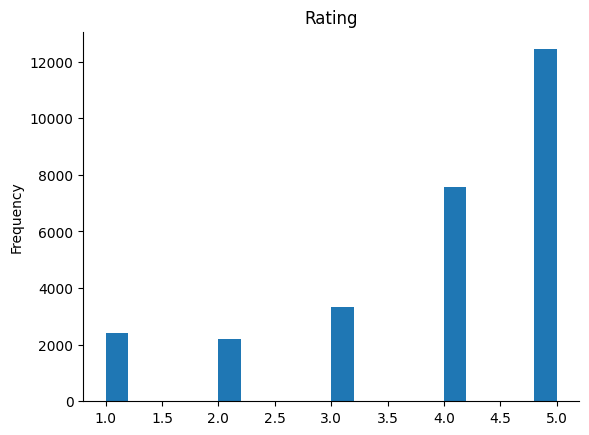

In [ ]:
show(df)

In [ ]:
run(sampled_data, "tokenizer_clean", "model_clean", False)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


169/169 ━━━━━━━━━━━━━━━━━━━━ 120s 688ms/step - accuracy: 0.1660 - loss: 3.8148 - mae: 1.5893 - val_accuracy: 0.1850 - val_loss: 1.8466 - val_mae: 1.1564
Epoch 2/3
169/169 ━━━━━━━━━━━━━━━━━━━━ 145s 704ms/step - accuracy: 0.2022 - loss: 1.8580 - mae: 1.1693 - val_accuracy: 0.1842 - val_loss: 1.6971 - val_mae: 1.0796
Epoch 3/3
169/169 ━━━━━━━━━━━━━━━━━━━━ 139s 687ms/step - accuracy: 0.1972 - loss: 1.4313 - mae: 0.9862 - val_accuracy: 0.1850 - val_loss: 1.4453 - val_mae: 0.9739
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.2083 - loss: 1.5907 - mae: 1.0338
1 - benchmark
MAE on Test Set: 1.026981767853101
MAE_ev on Test Set: 1.0269818305969238
Accuracy on Test Set: 0.19966666400432587
F1 Score on Test Set: 0.24
Custom Accuracy (within tolerance): 28.77%


In [ ]:
run2(sampled_data, "tokenizer_clean", "model_clean", False)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


169/169 ━━━━━━━━━━━━━━━━━━━━ 116s 671ms/step - accuracy: 0.1637 - loss: 1.5911 - mae: 1.5911 - val_accuracy: 0.1850 - val_loss: 1.1570 - val_mae: 1.1570
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 144s 682ms/step - accuracy: 0.1998 - loss: 1.1670 - mae: 1.1670 - val_accuracy: 0.1850 - val_loss: 1.0465 - val_mae: 1.0465
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 138s 654ms/step - accuracy: 0.1985 - loss: 0.9573 - mae: 0.9573 - val_accuracy: 0.1858 - val_loss: 0.9553 - val_mae: 0.9553
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 117s 692ms/step - accuracy: 0.2022 - loss: 0.8505 - mae: 0.8505 - val_accuracy: 0.1858 - val_loss: 0.9306 - val_mae: 0.9306
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 114s 673ms/step - accuracy: 0.2025 - loss: 0.7449 - mae: 0.7449 - val_accuracy: 0.1858 - val_loss: 0.9417 - val_mae: 0.9417
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 142s 678ms/step - accuracy: 0.2019 - loss: 0.6867 - mae: 0.6867 - val_accuracy: 0.1858 - val_loss: 0.9131 - val_mae: 0.9131
Epoch 7/20
169/169 ━━━━━━━━

(<Sequential name=sequential_22, built=True>,
 <keras.src.callbacks.history.History at 0x78adbae5f1c0>)

In [ ]:
run_int(sampled_data, "tokenizer_clean", "model_clean", False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
169/169 ━━━━━━━━━━━━━━━━━━━━ 117s 674ms/step - accuracy: 0.2282 - loss: 1.5952 - val_accuracy: 0.2167 - val_loss: 1.6405
Epoch 2/3
169/169 ━━━━━━━━━━━━━━━━━━━━ 141s 669ms/step - accuracy: 0.3305 - loss: 1.5317 - val_accuracy: 0.3625 - val_loss: 1.4177
Epoch 3/3
169/169 ━━━━━━━━━━━━━━━━━━━━ 144s 682ms/step - accuracy: 0.3895 - loss: 1.4089 - val_accuracy: 0.3758 - val_loss: 1.3942
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step
1 na int
F1 Score on Test Set: 0.34
Accuracy on Test Set: 0.36


In [ ]:
run2_int(sampled_data, "tokenizer_clean", "model_clean", False)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


169/169 ━━━━━━━━━━━━━━━━━━━━ 115s 668ms/step - accuracy: 0.2310 - loss: 1.5991 - val_accuracy: 0.3408 - val_loss: 1.4325
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 141s 657ms/step - accuracy: 0.3888 - loss: 1.3834 - val_accuracy: 0.3708 - val_loss: 1.3791
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 140s 645ms/step - accuracy: 0.4554 - loss: 1.2493 - val_accuracy: 0.3850 - val_loss: 1.3799
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 140s 639ms/step - accuracy: 0.5464 - loss: 1.0827 - val_accuracy: 0.4167 - val_loss: 1.3758
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 143s 642ms/step - accuracy: 0.6252 - loss: 0.9430 - val_accuracy: 0.4150 - val_loss: 1.4071
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 146s 667ms/step - accuracy: 0.6760 - loss: 0.8311 - val_accuracy: 0.4158 - val_loss: 1.5292
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 139s 647ms/step - accuracy: 0.7313 - loss: 0.7102 - val_accuracy: 0.4192 - val_loss: 1.6814
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step
2 na int
Accuracy on Test Set: 0.41033333333333

(<Sequential name=sequential_24, built=True>,
 <keras.src.callbacks.history.History at 0x78adae2ce950>)

In [ ]:
run2_bi(sampled_data, "tokenizer_clean", "model_clean", False)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


169/169 ━━━━━━━━━━━━━━━━━━━━ 545s 3s/step - accuracy: 0.2288 - loss: 1.5963 - val_accuracy: 0.3092 - val_loss: 1.4742
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 562s 3s/step - accuracy: 0.3215 - loss: 1.4721 - val_accuracy: 0.3183 - val_loss: 1.5340
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 538s 3s/step - accuracy: 0.3621 - loss: 1.4084 - val_accuracy: 0.3975 - val_loss: 1.3499
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 561s 3s/step - accuracy: 0.4637 - loss: 1.2076 - val_accuracy: 0.4017 - val_loss: 1.3907
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 562s 3s/step - accuracy: 0.5427 - loss: 1.0714 - val_accuracy: 0.4008 - val_loss: 1.4170
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 566s 3s/step - accuracy: 0.5827 - loss: 1.0082 - val_accuracy: 0.3992 - val_loss: 1.4908
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 644ms/step
Bi
Accuracy on Test Set: 0.39
F1 Score on Test Set: 0.37


(<Sequential name=sequential_25, built=True>,
 <keras.src.callbacks.history.History at 0x78adae135c30>)

In [ ]:
run2_gru(sampled_data, "tokenizer_clean", "model_clean", False)

In [ ]:
run2_cnn_rnn(sampled_data, "tokenizer_clean", "model_clean", False)

In [ ]:
run2_svm(df, "tokenizer_clean", "model_clean", False)

SVC
Accuracy on Test Set: 0.547372184483375
F1 Score on Test Set: 0.52


(SVC(C=1, kernel='linear', probability=True),
 TfidfVectorizer(max_features=5000, stop_words='english'))

In [ ]:
pipeline, label_encoder = run_logistic_regression(df, save = True)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


run_logistic_regression
Accuracy: 0.5067929924919556
F1 Score: 0.50

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.47      0.50       520
           1       0.32      0.27      0.29       461
           2       0.29      0.30      0.29       661
           3       0.39      0.39      0.39      1453
           4       0.65      0.68      0.66      2499

    accuracy                           0.51      5594
   macro avg       0.44      0.42      0.43      5594
weighted avg       0.50      0.51      0.50      5594

